In [303]:
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.manifold import TSNE
from sklearn import metrics
%matplotlib inline

In [2]:
df = pd.read_csv('column_3C_weka.csv')

In [3]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


In [9]:
df.shape

(310, 7)

Let's make EDA with ProfileReport.

In [23]:
report = ProfileReport(df, title='Spine disorders', html={'style':{'full_width':True}})

In [24]:
report.to_file(output_file="spinedisorders_report.html")

This report gave us information that we don't have missing values and duplicated rows values. Our values have a unimodal distribution. On the correlations graphics, we can see that we don't have correlations equal 1 between our values.

#### Scatter plot

Convert our class values to numeric values.
1 - Hernia ,
2 - Spondylolisthesis ,
3 - Normal

In [4]:
class_float = []
for element in df['class']:
    if element == 'Hernia':
        class_float.append(1)
    elif element == 'Spondylolisthesis':
        class_float.append(2)
    else:
        class_float.append(3)

Let's visualize our data by scatter plot, where x will be pelvic_radius, y - degree_spondylolisthesis.

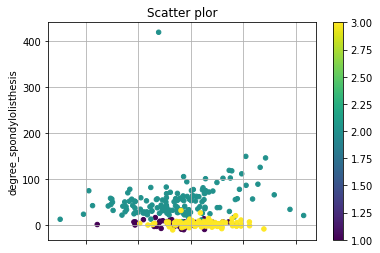

In [19]:
ax = df.plot.scatter(x='pelvic_radius',
                     y='degree_spondylolisthesis',
                     c=class_float,
                     colormap='viridis', 
                     title = 'Scatter plor',
                     grid = True)

We can see that values of 'Normal' and 'Hernia' classes are located in a similar location, but 'Spondylolisthesis' class is located separately.

#### Define numbers of clusters

Create a new dataframe without 'class' column.

In [68]:
data = df.drop(['class'], axis = 1)

In [32]:
data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


In [230]:
data_kmeans = data.loc[:,['degree_spondylolisthesis','pelvic_radius']]

In [231]:
mms = MinMaxScaler()
mms.fit(data_kmeans)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [232]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_kmeans)
    sum_of_squared_distances.append(km.inertia_)

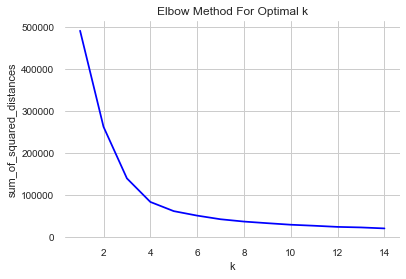

In [233]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

The k = 2 is the optimal for this dataset.

#### k-means clustering

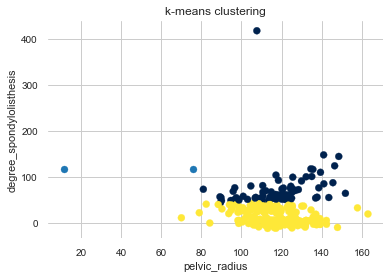

In [234]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(data_kmeans)
centroids = kmeans.cluster_centers_
x = [centroids[0][0], centroids[1][0]]
y = [centroids[0][1], centroids[1][1]]
labels = kmeans.predict(data_kmeans)
plt.scatter(data_kmeans['pelvic_radius'],data_kmeans['degree_spondylolisthesis'],c = labels, cmap='cividis')
plt.scatter(x, y, cmap = 'inferno')
plt.xlabel('pelvic_radius')
plt.ylabel('degree_spondylolisthesis')
plt.title('k-means clustering')
plt.grid()
plt.show()

In [235]:
centroids

array([[ 75.64961872, 118.15258208],
       [ 11.36639802, 117.85049222]])

We can see that our values have data outliers and our centroids are quite displaced. We can use 2 Standard Deviations from the Mean to excluding outliers. Let's calculate mean and standard deviation.

In [220]:
data_mean_pelvic, data_std_pelvic = mean(data['pelvic_radius']), std(data['pelvic_radius'])

In [221]:
data_mean_degree, data_std_degree = mean(data['degree_spondylolisthesis']), std(data['degree_spondylolisthesis'])

In [222]:
cut_off_pelvic = data_std_pelvic * 2
lower_pelvic, upper_pelvic = data_mean_pelvic - cut_off_pelvic, data_mean_pelvic + cut_off_pelvic

In [223]:
cut_off_degree = data_std_degree * 2
lower_degree, upper_degree = data_mean_degree - cut_off_degree, data_mean_degree + cut_off_degree

In [237]:
data_kmeans = data_kmeans.loc[(data_kmeans['pelvic_radius'] < upper_pelvic) & 
                                  (data_kmeans['degree_spondylolisthesis'] < upper_degree)]

In [238]:
data_kmeans = data_kmeans.loc[(data_kmeans['pelvic_radius'] > lower_pelvic) & 
                                  (data_kmeans['degree_spondylolisthesis'] > lower_degree)]

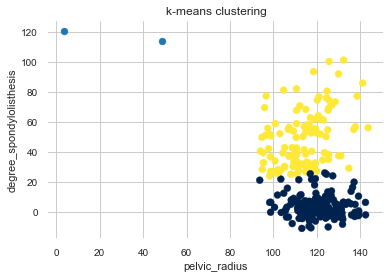

In [247]:
kmeans1 = KMeans(n_clusters = 2)
kmeans1.fit(data_kmeans)
centroids = kmeans1.cluster_centers_
x = [centroids[0][0], centroids[1][0]]
y = [centroids[0][1], centroids[1][1]]
labels = kmeans1.predict(data_kmeans)
plt.scatter(data_kmeans['pelvic_radius'],data_kmeans['degree_spondylolisthesis'],c = labels, cmap='cividis')
plt.scatter(x, y, cmap = 'inferno')
plt.xlabel('pelvic_radius')
plt.ylabel('degree_spondylolisthesis')
plt.title('k-means clustering')
plt.grid()
plt.show()

We can see that remove of outliers didn't help us.

#### Agglomerative Clustering

In [251]:
cluster_data = data.loc[:,['degree_spondylolisthesis','pelvic_radius']]

In [252]:
hiyerartical_cluster = AgglomerativeClustering(n_clusters = 2, affinity= "euclidean", linkage = "ward")
cluster = hiyerartical_cluster.fit_predict(cluster_data)

cluster_data["label_hc"] = cluster

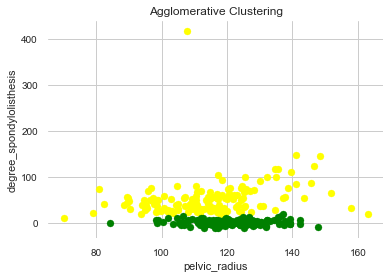

In [257]:
plt.scatter(x = cluster_data[cluster_data.label_hc == 0].pelvic_radius,y = cluster_data[cluster_data.label_hc == 0].degree_spondylolisthesis , color = "yellow")
plt.scatter(x = cluster_data[cluster_data.label_hc == 1].pelvic_radius,y = cluster_data[cluster_data.label_hc == 1].degree_spondylolisthesis , color = "green")
plt.grid()
plt.xlabel('pelvic_radius')
plt.ylabel('degree_spondylolisthesis')
plt.title('Agglomerative Clustering')
plt.show()

The best clustering was with affinity= "euclidean", linkage = "ward" in Agglomerative Clustering.

In my opinion it was the best parameters.

#### T - Distributed Stochastic Neighbor Embedding

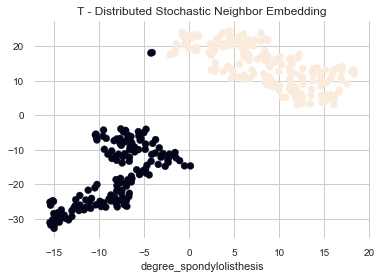

In [265]:
cluster_data1 = data.loc[:,['degree_spondylolisthesis','pelvic_radius']]
model = TSNE(learning_rate=100)
transformed = model.fit_transform(cluster_data1)
x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x,y, c =  cluster)
plt.xlabel('pelvic_radius')
plt.xlabel('degree_spondylolisthesis')
plt.title('T - Distributed Stochastic Neighbor Embedding')
plt.grid()
plt.show()

In [290]:
data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


In [297]:
data1  = data.loc[:,['degree_spondylolisthesis','pelvic_radius']]

In [314]:
X, y = data1, class_float

algorithms = []
algorithms.append(KMeans(n_clusters=3, random_state=1))
algorithms.append(AgglomerativeClustering(n_clusters=3))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.182245,0.279591,0.284191,0.465409,0.352895,0.548360
Agglomerative,0.664411,0.567330,0.570090,0.828991,0.675586,0.514428


The Agglomerative Clustering has a best metrics. 